In [43]:
import os
import dotenv
from termcolor import colored
import json
import numpy as np
import pandas as pd

from llm import LLM

dotenv.load_dotenv()
gpt35t = LLM("gpt-3.5-turbo")
gpt4 = LLM("gpt-4")

## 1. Make quadratic problems

In [44]:
from make_quadratic_problems import make_quadratic_problem

dotenv.load_dotenv()
llm = LLM("gpt-3.5-turbo")

for max in range(5, 50, 5):
    for factorable in [True, False]:
        filename = f'data/quadratic_problems/quadratic_problems_{max}_{factorable}.jsonl'
        if not os.path.exists(filename):
            print(f"Making problems ({max=}, {factorable=}), saving to {filename}", 'blue')
            with open(f'data/quadratic_problems/quadratic_problems_{max}_{factorable}.jsonl', 'w') as outfile:
                for _ in range(100):
                    outfile.write(make_quadratic_problem(max, factorable) + '\n')
        else:
            print(colored(f"Skipping making problems ({max=}, {factorable=}) because {filename} already exists", 'blue'))

Skipping making problems (max=5, factorable=True) because data/quadratic_problems/quadratic_problems_5_True.jsonl already exists
Skipping making problems (max=5, factorable=False) because data/quadratic_problems/quadratic_problems_5_False.jsonl already exists
Skipping making problems (max=10, factorable=True) because data/quadratic_problems/quadratic_problems_10_True.jsonl already exists
Skipping making problems (max=10, factorable=False) because data/quadratic_problems/quadratic_problems_10_False.jsonl already exists
Skipping making problems (max=15, factorable=True) because data/quadratic_problems/quadratic_problems_15_True.jsonl already exists
Skipping making problems (max=15, factorable=False) because data/quadratic_problems/quadratic_problems_15_False.jsonl already exists
Skipping making problems (max=20, factorable=True) because data/quadratic_problems/quadratic_problems_20_True.jsonl already exists
Skipping making problems (max=20, factorable=False) because data/quadratic_proble

## 2. Make quadratic-solving contexts with GPT-3.5-turbo and GPT-4

In [45]:
from make_quadratic_contexts import solve_quadratic_problems

# prompt is an unprincipled DoF here.
# pros: makes expected switching behavior clear
# cons: model is still in "assisstant mode", not "trying to solve the problem as efficiently as possible mode"
prompt = "Please find the roots of the quadratic equation {equation}. Start by trying to factor the equation. If you can't factor it, then use the quadratic formula. If you factor the equation successfully, do not use the quadratic formula."

# remember to force feed the model so it starts by attempting factoring! Otherwise switch rate will be too low.
false_start = "First, I'll try solving this equation by factoring."

for llm in [gpt35t, gpt4]:
    for problem_filename in os.listdir('data/quadratic_problems'):
        outfile = f'data/quadratic_contexts_{llm.model_name}/' + str.replace(problem_filename, 'problem', 'context')
        if not os.path.exists(outfile):
            print(f"Solving problems in {problem_filename}, writing to {outfile}")
            solve_quadratic_problems(problem_filename, prompt, false_start, llm)
        else:
            print(colored(f"Skipping solving problems in {problem_filename} because {outfile} already exists", 'blue'))

Skipping solving problems in quadratic_problems_10_True.jsonl because data/quadratic_contexts_gpt-3.5-turbo/quadratic_contexts_10_True.jsonl already exists
Skipping solving problems in quadratic_problems_5_False.jsonl because data/quadratic_contexts_gpt-3.5-turbo/quadratic_contexts_5_False.jsonl already exists
Skipping solving problems in quadratic_problems_45_True.jsonl because data/quadratic_contexts_gpt-3.5-turbo/quadratic_contexts_45_True.jsonl already exists
Skipping solving problems in quadratic_problems_15_True.jsonl because data/quadratic_contexts_gpt-3.5-turbo/quadratic_contexts_15_True.jsonl already exists
Skipping solving problems in quadratic_problems_40_True.jsonl because data/quadratic_contexts_gpt-3.5-turbo/quadratic_contexts_40_True.jsonl already exists
Skipping solving problems in quadratic_problems_25_True.jsonl because data/quadratic_contexts_gpt-3.5-turbo/quadratic_contexts_25_True.jsonl already exists
Skipping solving problems in quadratic_problems_10_False.jsonl b

## 3. Split contexts into prefixes, judge switching, and load into a dataframe

In [47]:
from new_switch_utils import make_non_decreasing, original_4

pref_res = 50

In [65]:
passages_35t = []
for filename in os.listdir('data/quadratic_contexts_gpt-3.5-turbo'):
    # filename has format quadratic_contexts_[difficulty]_[is_factorizable].jsonl
    # Each jsonl file is a list of objects, one json object per line. each object has 'equation' and 'context' field
    split_name = filename.split('_')
    difficulty = split_name[-2]
    is_factorizable = split_name[-1].split('.')[0]

    with open('data/quadratic_contexts_gpt-3.5-turbo/'+filename, 'r') as f:
        for line in f.readlines()[:1]:
            line_contents = json.loads(line)
            prefixes = [line_contents['context'][:pref_end] for pref_end in range(pref_res, len(line), pref_res)]
            measured_switching = [original_4(line_contents['context'], prefix) for prefix in prefixes]
            processed_switching = make_non_decreasing(measured_switching)
            switch_index = processed_switching.index(1) if 1 in processed_switching else len(processed_switching)
            for i, prefix in enumerate(prefixes):
                print(prefix)
                passages_35t.append({
                    'prefix': prefix,
                    'difficulty': difficulty,
                    'is_factorizable': 'Yes' if is_factorizable == 'True' else 'No',
                    'context': line_contents['context'],
                    'equation': line_contents['equation'],
                    'measured_switching': measured_switching,
                    'processed_switching': processed_switching,
                    'index': i,
                    'switch_index': switch_index
                })
passages_35t = pd.DataFrame(passages_35t)
passages_35t.to_csv('data/passages_35t.csv')

To factor the quadratic equation 7x^2 - 119x + 420
To factor the quadratic equation 7x^2 - 119x + 420 = 0, we first divide all coefficients by the GCF,
To factor the quadratic equation 7x^2 - 119x + 420 = 0, we first divide all coefficients by the GCF, which is 7:

x^2 - 17x + 60 = 0

Now, we can fact
To factor the quadratic equation 7x^2 - 119x + 420 = 0, we first divide all coefficients by the GCF, which is 7:

x^2 - 17x + 60 = 0

Now, we can factor the quadratic:

(x - 12)(x - 5) = 0

Therefore,
To factor the quadratic equation 7x^2 - 119x + 420 = 0, we first divide all coefficients by the GCF, which is 7:

x^2 - 17x + 60 = 0

Now, we can factor the quadratic:

(x - 12)(x - 5) = 0

Therefore, the roots of the quadratic equation 7x^2 - 119x +
To factor the quadratic equation 7x^2 - 119x + 420 = 0, we first divide all coefficients by the GCF, which is 7:

x^2 - 17x + 60 = 0

Now, we can factor the quadratic:

(x - 12)(x - 5) = 0

Therefore, the roots of the quadratic equation 7x^2 - 1

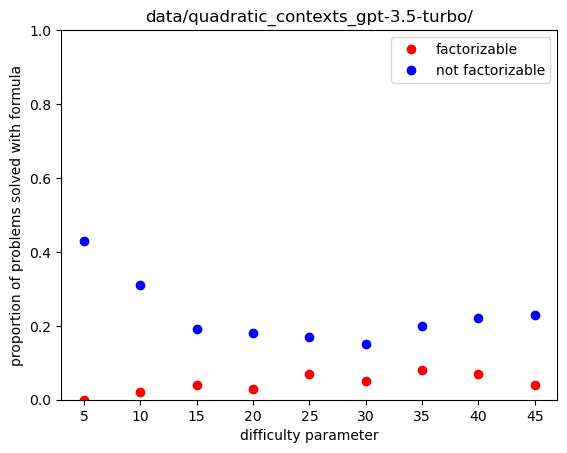

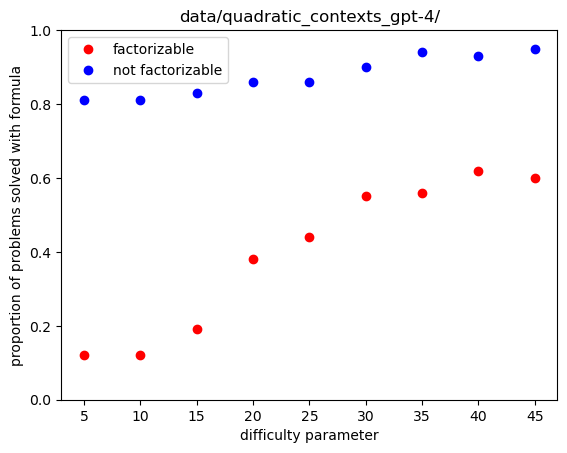

In [75]:
import matplotlib.pyplot as plt

for dir in ['data/quadratic_contexts_gpt-3.5-turbo/', 'data/quadratic_contexts_gpt-4/']:
    for filename in os.listdir(dir):
        split_name = filename.split('_')
        difficulty = split_name[-2]
        is_factorizable = split_name[-1].split('.')[0]
        with open(dir+'/'+filename, 'r') as f:
            v = np.mean(['formula' in line for line in f.readlines()])
            plt.plot(int(difficulty), v, 'ro' if is_factorizable == 'True' else 'bo')
    plt.title(dir)
    plt.xlabel('difficulty parameter')
    plt.ylabel('proportion of problems solved with formula')
    plt.ylim(0, 1)
    red_dot, = plt.plot([], [], 'ro', label='factorizable')
    blue_dot, = plt.plot([], [], 'bo', label='not factorizable')
    plt.legend(handles=[red_dot, blue_dot])
    plt.show()
            

## 4. Assess 1t and COT CPC for prefixes

## 5. Save results and analyze